In [33]:
# Imports standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import warnings
import joblib
import os
import xgboost as xgb

warnings.filterwarnings("ignore")

# Configuration affichage
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
sns.set_style("whitegrid")

print("✓ Imports OK")

✓ Imports OK


In [34]:
# Charger les données
initial_data = pd.read_csv("../data/interim/train_dataset_M1_interim.csv")
test_data = pd.read_csv("../data/interim/test_dataset_M1_interim.csv")

initial_data['set_origin'] = 'train'
test_data['Purchase'] = None
test_data['set_origin'] = 'test'

# 2. Concatenate vertically
# axis=0 means "stack rows"
df = pd.concat([initial_data, test_data], axis=0, ignore_index=True)
train_full = df[df['set_origin'] == 'train'].copy

print(f"📊 Dataset shape: {df.shape}")
print(f"📅 Période: Day {df['Day'].min()} à {df['Day'].max()}")
print(f"🎯 Target balance: {df['Purchase'].value_counts(normalize=True)}")

# Afficher les premières lignes
display(df.head())

# %%
# Vérifier les types de colonnes
print("🔍 Types de données:")
display(df.dtypes)

📊 Dataset shape: (20000, 22)
📅 Période: Day 1.0 à 100.0
🎯 Target balance: Purchase
0    0.631889
1    0.368111
Name: proportion, dtype: float64


,id,Age,Gender,Reviews_Read,Price,Discount,Category,Items_In_Cart,Time_of_Day,Email_Interaction,Device_Type,Payment_Method,Referral_Source,Socioeconomic_Status_Score,Engagement_Score,AB_Bucket,Price_Sine,Session_ID,Day,Campaign_Period,Purchase,set_origin
0,1,NaN,1.0,3.0,592.975,22.0,1.0,6.0,afternoon,0.0,Mobile,Credit,Social_media,7.26,1.856520,3.0,0.999047,S0000003,59.0,False,0,train
1,2,25.0,1.0,1.0,511.279,12.0,0.0,3.0,morning,1.0,Tablet,Cash,Social_media,8.30,1.868138,5.0,-0.129689,S0000005,29.0,True,1,train
2,3,22.0,0.0,3.0,218.360,2.0,1.0,4.0,evening,1.0,Mobile,Bank,Social_media,6.61,1.223445,0.0,-0.421646,S0000007,16.0,False,0,train
3,4,24.0,0.0,3.0,313.781,1.0,3.0,0.0,evening,1.0,Mobile,PayPal,Social_media,10.51,0.359684,1.0,-0.988239,S0000008,53.0,False,0,train
4,5,35.0,1.0,1.0,495.088,13.0,0.0,2.0,evening,0.0,Mobile,Cash,Social_media,8.33,3.848580,2.0,0.695737,S0000009,10.0,False,0,train


🔍 Types de données:


id                              int64
Age                           float64
Gender                        float64
Reviews_Read                  float64
Price                         float64
Discount                      float64
Category                      float64
Items_In_Cart                 float64
Time_of_Day                    object
Email_Interaction             float64
Device_Type                    object
Payment_Method                 object
Referral_Source                object
Socioeconomic_Status_Score    float64
Engagement_Score              float64
AB_Bucket                     float64
Price_Sine                    float64
Session_ID                     object
Day                           float64
Campaign_Period                  bool
Purchase                       object
set_origin                     object
dtype: object

In [35]:
# Statistiques de valeurs manquantes
print("❌ Valeurs manquantes par colonne:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({"Missing_Count": missing, "Missing_Pct": missing_pct})
display(
    missing_df[missing_df["Missing_Count"] > 0].sort_values(
        "Missing_Pct", ascending=False
    )
)

❌ Valeurs manquantes par colonne:


,Missing_Count,Missing_Pct
Purchase,6265,31.32
Age,3000,15.00
Price,923,4.61
Reviews_Read,400,2.00
Gender,400,2.00
Category,400,2.00
Discount,400,2.00
Time_of_Day,400,2.00
Email_Interaction,400,2.00
Device_Type,400,2.00


In [36]:
# Vérifier les valeurs uniques des catégorielles
print("📂 Catégories uniques:")
for col in df.select_dtypes(include="object").columns:
    print(f"\n{col}: {df[col].nunique()} valeurs")
    print(f"  → {df[col].unique()[:10]}")

📂 Catégories uniques:

Time_of_Day: 3 valeurs
  → ['afternoon' 'morning' 'evening' nan]

Device_Type: 3 valeurs
  → ['Mobile' 'Tablet' 'Desktop' nan]

Payment_Method: 4 valeurs
  → ['Credit' 'Cash' 'Bank' 'PayPal' nan]

Referral_Source: 5 valeurs
  → ['Social_media' 'Direct' 'Search_engine' 'Ads' 'Email' nan]

Session_ID: 19600 valeurs
  → ['S0000003' 'S0000005' 'S0000007' 'S0000008' 'S0000009' 'S0000010'
 'S0000011' 'S0000013' 'S0000014' 'S0000016']

Purchase: 2 valeurs
  → [0 1 None]

set_origin: 2 valeurs
  → ['train' 'test']


In [37]:
# Split temporel
train = df[(df["Day"] <= 60) & (df['set_origin'] == 'train')].copy()
train = train.drop(columns=['set_origin'])
val = df[(df["Day"] > 60) & (df["Day"] <= 70) & (df['set_origin'] == 'train')].copy()
val = val.drop(columns=['set_origin'])
#test data
test = df[df['set_origin'] == 'test'].copy()
test = test.drop(columns=['set_origin'])

print(f"📦 Train: {len(train):,} lignes ({len(train)/len(df)*100:.1f}%)")
print(f"📦 Val:   {len(val):,} lignes ({len(val)/len(df)*100:.1f}%)")
print(f"📦 Test:  {len(test):,} lignes ({len(test)/len(df)*100:.1f}%)")

📦 Train: 11,766 lignes (58.8%)
📦 Val:   1,969 lignes (9.8%)
📦 Test:  6,265 lignes (31.3%)


In [38]:
# Vérifier la distribution de la target
print("\n🎯 Distribution Purchase:")
print(f"  Train: {train['Purchase'].mean():.2%}")
print(f"  Val:   {val['Purchase'].mean():.2%}")
if len(test) > 0 and "Purchase" in test.columns:
    print(f"  Test:  {test['Purchase'].mean():.2%}")


🎯 Distribution Purchase:
  Train: 37.44%
  Val:   33.06%
  Test:  nan%


In [39]:
def engineer_features(df, campaign_days=None, is_train=True):
    """
    Crée toutes les features engineerées

    Parameters:
    -----------
    df : DataFrame
        Données à transformer
    campaign_days : list
        Liste des jours de campagne (appris sur train)
    is_train : bool
        Si True, apprend les campaign_days

    Returns:
    --------
    df : DataFrame transformé
    campaign_days : list (si is_train=True)
    """

    df = df.copy()

    # === 1. FEATURES PRIX ===
    print("💰 Features prix...")
    # Montant réel de la réduction
    df["Effective_Discount"] = df["Price"] * df["Discount"] / 100

    # Prix après réduction
    df["Net_Price"] = df["Price"] * (1 - df["Discount"] / 100)

    # Buckets de prix (robuste aux outliers)
    df["Price_Bucket"] = pd.qcut(df["Price"], q=5, labels=False, duplicates="drop")

    # === 2. FEATURES ENGAGEMENT ===
    print("🎯 Features engagement...")
    # Interaction email × score d'engagement
    df["Email_x_Engagement"] = df["Email_Interaction"] * df["Engagement_Score"]

    # Items dans le panier × engagement
    df["Cart_x_Engagement"] = df["Items_In_Cart"] * df["Engagement_Score"]

    # === 3. FEATURES CAMPAGNE (insights EDA) ===
    print("📢 Features campagne...")
    # Tablet pendant campagne (très performant selon EDA)
    df["Tablet_During_Campaign"] = (
        (df["Device_Type"] == "Tablet") & (df["Campaign_Period"])
    ).astype(int)

    # Desktop pendant campagne
    df["Desktop_During_Campaign"] = (
        (df["Device_Type"] == "Desktop") & (df["Campaign_Period"])
    ).astype(int)

    # Distance au campaign le plus proche
    if is_train:
        # Apprendre quels jours sont des campagnes
        campaign_days = sorted(df[df["Campaign_Period"] == True]["Day"].unique())
        print(
            f"  📅 Jours de campagne détectés: {campaign_days[:5]}... ({len(campaign_days)} jours)"
        )

    if campaign_days is not None and len(campaign_days) > 0:
        df["Day_to_Campaign"] = df["Day"].apply(
            lambda d: min([abs(d - cd) for cd in campaign_days])
        )
    else:
        df["Day_to_Campaign"] = 999  # Valeur par défaut si pas de campagne

    # === 4. FEATURES CATÉGORIELLES ===
    print("📂 Features catégorielles...")
    # Catégories haute valeur (0, 1, 2 selon EDA)
    df["HighValue_Category"] = df["Category"].isin([0.0, 1.0, 2.0]).astype(int)

    # Email + Device premium (Tablet/Desktop)
    df["Email_Device_High"] = (
        (df["Email_Interaction"] == 1.0)
        & (df["Device_Type"].isin(["Tablet", "Desktop"]))
    ).astype(int)

    print(f"✓ {len(df.columns)} colonnes après feature engineering")

    if is_train:
        return df, campaign_days
    else:
        return df

In [40]:
# Créer les features sur TRAIN d'abord (pour apprendre campaign_days)
print("=" * 60)
print("FEATURE ENGINEERING - TRAIN")
print("=" * 60)
train_featured, campaign_days = engineer_features(train, is_train=True)

FEATURE ENGINEERING - TRAIN
💰 Features prix...
🎯 Features engagement...
📢 Features campagne...
  📅 Jours de campagne détectés: [np.float64(25.0), np.float64(26.0), np.float64(27.0), np.float64(28.0), np.float64(29.0)]... (26 jours)
📂 Features catégorielles...
✓ 31 colonnes après feature engineering


In [41]:
# Puis sur VAL et TEST en utilisant les campaign_days du train
print("\n" + "=" * 60)
print("FEATURE ENGINEERING - VAL")
print("=" * 60)
val_featured = engineer_features(val, campaign_days=campaign_days, is_train=False)

if len(test) > 0:
    print("\n" + "=" * 60)
    print("FEATURE ENGINEERING - TEST")
    print("=" * 60)
    test_featured = engineer_features(test, campaign_days=campaign_days, is_train=False)
else:
    test_featured = test.copy()


FEATURE ENGINEERING - VAL
💰 Features prix...
🎯 Features engagement...
📢 Features campagne...
📂 Features catégorielles...
✓ 31 colonnes après feature engineering

FEATURE ENGINEERING - TEST
💰 Features prix...
🎯 Features engagement...
📢 Features campagne...
📂 Features catégorielles...
✓ 31 colonnes après feature engineering


In [42]:
len(test)

6265

In [43]:
# Vérifier les nouvelles features
print("🆕 Nouvelles features créées:")
new_features = [col for col in train_featured.columns if col not in df.columns]
print(new_features)

# Afficher quelques statistiques
display(train_featured[new_features].describe())

🆕 Nouvelles features créées:
['Effective_Discount', 'Net_Price', 'Price_Bucket', 'Email_x_Engagement', 'Cart_x_Engagement', 'Tablet_During_Campaign', 'Desktop_During_Campaign', 'Day_to_Campaign', 'HighValue_Category', 'Email_Device_High']


,Effective_Discount,Net_Price,Price_Bucket,Email_x_Engagement,Cart_x_Engagement,Tablet_During_Campaign,Desktop_During_Campaign,Day_to_Campaign,HighValue_Category,Email_Device_High
count,10988.000000,10988.000000,11216.000000,11312.000000,11297.000000,11766.000000,11766.000000,11766.000000,11766.000000,11766.000000
mean,141.852051,421.080031,1.999822,1.032998,7.884988,0.062468,0.168281,5.999575,0.588135,0.237804
std,266.103561,581.592408,1.414340,1.492498,9.160557,0.242014,0.374132,7.307519,0.492192,0.425756
min,0.000000,2.870450,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.760085,182.384527,1.000000,0.000000,1.795998,0.000000,0.000000,0.000000,0.000000,0.000000
50%,93.761070,356.140610,2.000000,0.000000,4.866455,0.000000,0.000000,3.000000,1.000000,0.000000
75%,188.843385,549.497975,3.000000,1.904209,10.842206,0.000000,0.000000,10.000000,1.000000,0.000000
max,11803.141054,12601.978185,4.000000,6.398595,179.160658,1.000000,1.000000,24.000000,1.000000,1.000000


In [44]:
def add_missing_indicators(df, cols_with_missing=None, is_train=True, threshold=0.01):
    """
    Ajoute des indicateurs de valeurs manquantes

    Parameters:
    -----------
    df : DataFrame
    cols_with_missing : list
        Colonnes à traiter (appris sur train)
    is_train : bool
        Si True, détecte les colonnes avec >threshold missing
    threshold : float
        Seuil de % de missing pour créer un flag

    Returns:
    --------
    df : DataFrame avec flags
    cols_with_missing : list
    """

    df = df.copy()

    if is_train:
        # Détecter les colonnes avec >threshold de missing
        missing_pct = df.isnull().sum() / len(df)
        cols_with_missing = missing_pct[missing_pct > threshold].index.tolist()
        print(f"📍 {len(cols_with_missing)} colonnes avec >{threshold*100}% missing:")
        for col in cols_with_missing:
            pct = missing_pct[col] * 100
            print(f"  - {col}: {pct:.2f}%")

    # Ajouter les flags
    if cols_with_missing:
        for col in cols_with_missing:
            if col in df.columns:
                df[f"{col}_missing"] = df[col].isnull().astype(int)

    if is_train:
        return df, cols_with_missing
    else:
        return df

In [45]:
# Ajouter les missing indicators
print("=" * 60)
print("MISSING INDICATORS")
print("=" * 60)

train_featured, cols_with_missing = add_missing_indicators(
    train_featured, is_train=True, threshold=0.01
)

val_featured = add_missing_indicators(
    val_featured, cols_with_missing=cols_with_missing, is_train=False
)

if len(test_featured) > 0:
    test_featured = add_missing_indicators(
        test_featured, cols_with_missing=cols_with_missing, is_train=False
    )

print(f"\n✓ Flags ajoutés pour: {cols_with_missing}")

MISSING INDICATORS
📍 20 colonnes avec >1.0% missing:
  - Age: 15.19%
  - Gender: 1.87%
  - Reviews_Read: 2.14%
  - Price: 4.67%
  - Discount: 2.03%
  - Category: 2.08%
  - Items_In_Cart: 2.01%
  - Time_of_Day: 1.99%
  - Email_Interaction: 1.94%
  - Device_Type: 1.99%
  - Socioeconomic_Status_Score: 2.02%
  - Engagement_Score: 2.00%
  - AB_Bucket: 1.95%
  - Price_Sine: 2.12%
  - Session_ID: 2.08%
  - Effective_Discount: 6.61%
  - Net_Price: 6.61%
  - Price_Bucket: 4.67%
  - Email_x_Engagement: 3.86%
  - Cart_x_Engagement: 3.99%

✓ Flags ajoutés pour: ['Age', 'Gender', 'Reviews_Read', 'Price', 'Discount', 'Category', 'Items_In_Cart', 'Time_of_Day', 'Email_Interaction', 'Device_Type', 'Socioeconomic_Status_Score', 'Engagement_Score', 'AB_Bucket', 'Price_Sine', 'Session_ID', 'Effective_Discount', 'Net_Price', 'Price_Bucket', 'Email_x_Engagement', 'Cart_x_Engagement']


In [46]:
def impute_numeric_features(train, val, test=None):
    """
    Impute les features numériques avec la médiane du train

    Returns:
    --------
    train, val, test (imputés)
    impute_values (dict des médianes)
    """

    train = train.copy()
    val = val.copy()
    if test is not None:
        test = test.copy()

    # Identifier les colonnes numériques avec des NaN
    numeric_cols = train.select_dtypes(include=[np.number]).columns
    cols_to_impute = [col for col in numeric_cols if train[col].isnull().any()]

    print(f"🔢 Imputation de {len(cols_to_impute)} colonnes numériques:")

    impute_values = {}

    for col in cols_to_impute:
        # Calculer la médiane sur TRAIN uniquement
        median_val = train[col].median()
        impute_values[col] = median_val

        # Appliquer sur train, val, test
        train[col] = train[col].fillna(median_val)
        val[col] = val[col].fillna(median_val)
        if test is not None:
            if col in test.columns:  # <-- Ajoutez cette vérification
                test[col] = test[col].fillna(median_val)

        print(f"  - {col}: médiane = {median_val:.2f}")

    print(f"\n✓ Imputation terminée")

    if test is not None:
        return train, val, test, impute_values
    else:
        return train, val, None, impute_values

In [47]:
def impute_categorical_features(train, val, test=None):
    """
    Impute les features catégorielles avec 'Unknown'
    """

    train = train.copy()
    val = val.copy()
    if test is not None:
        test = test.copy()

    cat_cols = train.select_dtypes(include="object").columns
    cols_to_impute = [col for col in cat_cols if train[col].isnull().any()]

    print(f"📂 Imputation de {len(cols_to_impute)} colonnes catégorielles:")

    for col in cols_to_impute:
        missing_count = train[col].isnull().sum()
        train[col] = train[col].fillna("Unknown")
        val[col] = val[col].fillna("Unknown")
        if test is not None:
            test[col] = test[col].fillna("Unknown")

        print(f"  - {col}: {missing_count} valeurs → 'Unknown'")

    print(f"✓ Imputation terminée")

    if test is not None:
        return train, val, test
    else:
        return train, val, None

In [48]:
# Imputation
print("=" * 60)
print("IMPUTATION - NUMÉRIQUES")
print("=" * 60)

train_featured, val_featured, test_featured, impute_vals = impute_numeric_features(
    train_featured, val_featured, test_featured
)

print("\n" + "=" * 60)
print("IMPUTATION - CATÉGORIELLES")
print("=" * 60)

train_featured, val_featured, test_featured = impute_categorical_features(
    train_featured, val_featured, test_featured
)

IMPUTATION - NUMÉRIQUES
🔢 Imputation de 17 colonnes numériques:
  - Age: médiane = 28.00
  - Gender: médiane = 0.00
  - Reviews_Read: médiane = 3.00
  - Price: médiane = 499.72
  - Discount: médiane = 25.00
  - Category: médiane = 2.00
  - Items_In_Cart: médiane = 3.00
  - Email_Interaction: médiane = 0.00
  - Socioeconomic_Status_Score: médiane = 4.53
  - Engagement_Score: médiane = 2.11
  - AB_Bucket: médiane = 3.00
  - Price_Sine: médiane = 0.03
  - Effective_Discount: médiane = 93.76
  - Net_Price: médiane = 356.14
  - Price_Bucket: médiane = 2.00
  - Email_x_Engagement: médiane = 0.00
  - Cart_x_Engagement: médiane = 4.87

✓ Imputation terminée

IMPUTATION - CATÉGORIELLES
📂 Imputation de 5 colonnes catégorielles:
  - Time_of_Day: 234 valeurs → 'Unknown'
  - Device_Type: 234 valeurs → 'Unknown'
  - Payment_Method: 34 valeurs → 'Unknown'
  - Referral_Source: 31 valeurs → 'Unknown'
  - Session_ID: 245 valeurs → 'Unknown'
✓ Imputation terminée


In [49]:
# Vérifier qu'il n'y a plus de NaN
print("🔍 Vérification des valeurs manquantes après imputation:")
print(f"  Train: {train_featured.isnull().sum().sum()} NaN")
print(f"  Val:   {val_featured.isnull().sum().sum()} NaN")
if len(test_featured) > 0:
    print(f"  Test:  {test_featured.isnull().sum().sum()} NaN")

🔍 Vérification des valeurs manquantes après imputation:
  Train: 0 NaN
  Val:   0 NaN
  Test:  7065 NaN


In [50]:
def handle_rare_categories(train, val, test=None, cat_features=None, threshold=0.01):
    """
    Groupe les catégories rares (<threshold) en 'Other'

    Parameters:
    -----------
    threshold : float
        % minimum pour garder une catégorie

    Returns:
    --------
    train, val, test (transformés)
    known_categories (dict)
    """

    train = train.copy()
    val = val.copy()
    if test is not None:
        test = test.copy()

    if cat_features is None:
        cat_features = train.select_dtypes(include="object").columns.tolist()

    known_categories = {}

    print(f"📊 Groupement des catégories rares (<{threshold*100}%):")

    for col in cat_features:
        if col not in train.columns:
            continue

        # Compter les occurrences dans train
        value_counts = train[col].value_counts()
        freq = value_counts / len(train)

        # Garder seulement les catégories fréquentes
        valid_cats = freq[freq >= threshold].index.tolist()
        known_categories[col] = valid_cats

        rare_count = len(value_counts) - len(valid_cats)

        if rare_count > 0:
            print(f"  - {col}: {rare_count}/{len(value_counts)} catégories → 'Other'")

            # Remplacer les rares par 'Other'
            train[col] = train[col].apply(lambda x: x if x in valid_cats else "Other")
            val[col] = val[col].apply(lambda x: x if x in valid_cats else "Other")
            if test is not None:
                test[col] = test[col].apply(lambda x: x if x in valid_cats else "Other")

    print(f"\n✓ Groupement terminé")

    if test is not None:
        return train, val, test, known_categories
    else:
        return train, val, None, known_categories

In [51]:
# Définir les features catégorielles
cat_features = [
    "Device_Type",
    "Time_of_Day",
    "Payment_Method",
    "Referral_Source",
    "Category",
]

print("=" * 60)
print("RARE CATEGORIES HANDLING")
print("=" * 60)

train_featured, val_featured, test_featured, known_cats = handle_rare_categories(
    train_featured,
    val_featured,
    test_featured,
    cat_features=cat_features,
    threshold=0.01,
)

# Afficher les catégories gardées
print("\n📋 Catégories valides par feature:")
for col, cats in known_cats.items():
    print(f"  {col}: {cats}")

RARE CATEGORIES HANDLING
📊 Groupement des catégories rares (<1.0%):
  - Payment_Method: 1/5 catégories → 'Other'
  - Referral_Source: 1/6 catégories → 'Other'

✓ Groupement terminé

📋 Catégories valides par feature:
  Device_Type: ['Mobile', 'Desktop', 'Tablet', 'Unknown']
  Time_of_Day: ['evening', 'afternoon', 'morning', 'Unknown']
  Payment_Method: ['PayPal', 'Cash', 'Bank', 'Credit']
  Referral_Source: ['Search_engine', 'Direct', 'Social_media', 'Email', 'Ads']
  Category: [2.0, 1.0, 4.0, 0.0, 3.0]


In [52]:
def prepare_catboost_data(
    train,
    val,
    test,
    cat_features,
    target_col="Purchase",
    id_col="id",
    session_col="Session_ID",
):
    """
    Prépare les données pour CatBoost

    Returns:
    --------
    X_train, y_train, X_val, y_val, X_test, cat_indices
    """

    # Convertir les catégorielles en string
    train = train.copy()
    val = val.copy()
    test = test.copy() if test is not None and len(test) > 0 else None

    for col in cat_features:
        if col in train.columns:
            train[col] = train[col].astype(str)
            val[col] = val[col].astype(str)
            if test is not None:
                test[col] = test[col].astype(str)

    # Colonnes à drop
    drop_cols = [target_col, id_col, session_col]
    drop_cols = [c for c in drop_cols if c in train.columns]

    # Séparer features et target
    X_train = train.drop(columns=drop_cols)
    y_train = train[target_col]

    X_val = val.drop(columns=drop_cols)
    y_val = val[target_col] if target_col in val.columns else None

    if test is not None:
        X_test = (
            test.drop(columns=drop_cols)
            if target_col in test.columns
            else test.drop(
                columns=[c for c in [id_col, session_col] if c in test.columns]
            )
        )
    else:
        X_test = None

    # Indices des colonnes catégorielles
    cat_indices = [
        X_train.columns.get_loc(col) for col in cat_features if col in X_train.columns
    ]

    print("📦 CatBoost Data Ready:")
    print(f"  X_train: {X_train.shape}")
    print(f"  X_val:   {X_val.shape}")
    if X_test is not None:
        print(f"  X_test:  {X_test.shape}")
    print(f"  Categorical indices: {cat_indices}")
    print(f"  Categorical features: {[X_train.columns[i] for i in cat_indices]}")

    return X_train, y_train, X_val, y_val, X_test, cat_indices


print("=" * 60)
print("PIPELINE 1 : CATBOOST")
print("=" * 60)

X_train_cb, y_train_cb, X_val_cb, y_val_cb, X_test_cb, cat_indices = (
    prepare_catboost_data(
        train_featured, val_featured, test_featured, cat_features=cat_features
    )
)

# Afficher les premières lignes
print("\n📊 Aperçu X_train_cb:")
display(X_train_cb.head())

# Vérifier les types
print("\n🔍 Types de colonnes:")
print(X_train_cb.dtypes.value_counts())

PIPELINE 1 : CATBOOST
📦 CatBoost Data Ready:
  X_train: (11766, 48)
  X_val:   (1969, 48)
  X_test:  (6265, 48)
  Categorical indices: [9, 7, 10, 11, 5]
  Categorical features: ['Device_Type', 'Time_of_Day', 'Payment_Method', 'Referral_Source', 'Category']

📊 Aperçu X_train_cb:


,Age,Gender,Reviews_Read,Price,Discount,Category,Items_In_Cart,Time_of_Day,Email_Interaction,Device_Type,Payment_Method,Referral_Source,Socioeconomic_Status_Score,Engagement_Score,AB_Bucket,Price_Sine,Day,Campaign_Period,Effective_Discount,Net_Price,Price_Bucket,Email_x_Engagement,Cart_x_Engagement,Tablet_During_Campaign,Desktop_During_Campaign,Day_to_Campaign,HighValue_Category,Email_Device_High,Age_missing,Gender_missing,Reviews_Read_missing,Price_missing,Discount_missing,Category_missing,Items_In_Cart_missing,Time_of_Day_missing,Email_Interaction_missing,Device_Type_missing,Socioeconomic_Status_Score_missing,Engagement_Score_missing,AB_Bucket_missing,Price_Sine_missing,Session_ID_missing,Effective_Discount_missing,Net_Price_missing,Price_Bucket_missing,Email_x_Engagement_missing,Cart_x_Engagement_missing
0,28.0,1.0,3.0,592.975,22.0,1.0,6.0,afternoon,0.0,Mobile,Credit,Social_media,7.26,1.856520,3.0,0.999047,59.0,False,130.45450,462.52050,2.0,0.000000,11.139119,0,0,9.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,25.0,1.0,1.0,511.279,12.0,0.0,3.0,morning,1.0,Tablet,Cash,Social_media,8.30,1.868138,5.0,-0.129689,29.0,True,61.35348,449.92552,2.0,1.868138,5.604415,1,0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,22.0,0.0,3.0,218.360,2.0,1.0,4.0,evening,1.0,Mobile,Bank,Social_media,6.61,1.223445,0.0,-0.421646,16.0,False,4.36720,213.99280,1.0,1.223445,4.893782,0,0,9.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,24.0,0.0,3.0,313.781,1.0,3.0,0.0,evening,1.0,Mobile,PayPal,Social_media,10.51,0.359684,1.0,-0.988239,53.0,False,3.13781,310.64319,1.0,0.359684,0.000000,0,0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,35.0,1.0,1.0,495.088,13.0,0.0,2.0,evening,0.0,Mobile,Cash,Social_media,8.33,3.848580,2.0,0.695737,10.0,False,64.36144,430.72656,2.0,0.000000,7.697160,0,0,15.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



🔍 Types de colonnes:
int64      24
float64    18
object      5
bool        1
Name: count, dtype: int64


In [53]:
def prepare_classic_data(
    train,
    val,
    test,
    cat_features,
    scale=True,
    target_col="Purchase",
    id_col="id",
    session_col="Session_ID",
):
    """
    Prépare les données pour modèles classiques (one-hot + scaling)

    Returns:
    --------
    X_train, y_train, X_val, y_val, X_test, scaler
    """

    train = train.copy()
    val = val.copy()
    test = test.copy() if test is not None and len(test) > 0 else None

    # Colonnes à drop
    drop_cols = [target_col, id_col, session_col]
    drop_cols = [c for c in drop_cols if c in train.columns]

    # Séparer features et target
    X_train = train.drop(columns=drop_cols)
    y_train = train[target_col]

    X_val = val.drop(columns=drop_cols)
    y_val = val[target_col] if target_col in val.columns else None

    if test is not None:
        X_test = (
            test.drop(columns=drop_cols)
            if target_col in test.columns
            else test.drop(
                columns=[c for c in [id_col, session_col] if c in test.columns]
            )
        )
    else:
        X_test = None

    print("🔄 One-hot encoding...")

    # One-hot encoding
    X_train_encoded = pd.get_dummies(X_train, columns=cat_features, drop_first=True)
    X_val_encoded = pd.get_dummies(X_val, columns=cat_features, drop_first=True)
    if X_test is not None:
        X_test_encoded = pd.get_dummies(X_test, columns=cat_features, drop_first=True)
    else:
        X_test_encoded = None

    # Aligner les colonnes (val/test doivent avoir les mêmes que train)
    train_cols = X_train_encoded.columns.tolist()

    # Ajouter les colonnes manquantes dans val
    missing_in_val = set(train_cols) - set(X_val_encoded.columns)
    for col in missing_in_val:
        X_val_encoded[col] = 0

    # Supprimer les colonnes en trop dans val
    extra_in_val = set(X_val_encoded.columns) - set(train_cols)
    X_val_encoded = X_val_encoded.drop(columns=list(extra_in_val))

    # Réordonner les colonnes
    X_val_encoded = X_val_encoded[train_cols]

    # Même chose pour test
    if X_test_encoded is not None:
        missing_in_test = set(train_cols) - set(X_test_encoded.columns)
        for col in missing_in_test:
            X_test_encoded[col] = 0

        extra_in_test = set(X_test_encoded.columns) - set(train_cols)
        X_test_encoded = X_test_encoded.drop(columns=list(extra_in_test))

        X_test_encoded = X_test_encoded[train_cols]

    print(f"  ✓ Train: {X_train_encoded.shape[1]} features après encoding")
    print(
        f"  ✓ Val:   {len(missing_in_val)} colonnes ajoutées, {len(extra_in_val)} supprimées"
    )
    if X_test_encoded is not None:
        print(
            f"  ✓ Test:  {len(missing_in_test)} colonnes ajoutées, {len(extra_in_test)} supprimées"
        )

    # Scaling
    scaler = None
    if scale:
        print("\n📏 Scaling (StandardScaler)...")
        scaler = StandardScaler()

        # Fit sur train uniquement
        X_train_encoded = pd.DataFrame(
            scaler.fit_transform(X_train_encoded),
            columns=X_train_encoded.columns,
            index=X_train_encoded.index,
        )

        # Transform sur val et test
        X_val_encoded = pd.DataFrame(
            scaler.transform(X_val_encoded),
            columns=X_val_encoded.columns,
            index=X_val_encoded.index,
        )

        if X_test_encoded is not None:
            X_test_encoded = pd.DataFrame(
                scaler.transform(X_test_encoded),
                columns=X_test_encoded.columns,
                index=X_test_encoded.index,
            )

        print("  ✓ Scaling terminé")

    print("\n📦 Classic ML Data Ready:")
    print(f"  X_train: {X_train_encoded.shape}")
    print(f"  X_val:   {X_val_encoded.shape}")
    if X_test_encoded is not None:
        print(f"  X_test:  {X_test_encoded.shape}")

    return X_train_encoded, y_train, X_val_encoded, y_val, X_test_encoded, scaler


print("=" * 60)
print("PIPELINE 2 : CLASSIC ML (ONE-HOT + SCALING)")
print("=" * 60)

X_train_cls, y_train_cls, X_val_cls, y_val_cls, X_test_cls, scaler = (
    prepare_classic_data(
        train_featured,
        val_featured,
        test_featured,
        cat_features=cat_features,
        scale=True,
    )
)

# Afficher les premières lignes
print("\n📊 Aperçu X_train_cls:")
display(X_train_cls.head())

# Vérifier la distribution (devrait être ~N(0,1) après scaling)
print("\n📊 Statistiques après scaling:")
display(X_train_cls.describe().loc[["mean", "std"]].T.head(10))


# Test rapide Logistic Regression sur le pipeline classic

print("=" * 60)
print("VALIDATION RAPIDE - LOGISTIC REGRESSION")
print("=" * 60)

PIPELINE 2 : CLASSIC ML (ONE-HOT + SCALING)
🔄 One-hot encoding...
  ✓ Train: 62 features après encoding
  ✓ Val:   0 colonnes ajoutées, 0 supprimées
  ✓ Test:  0 colonnes ajoutées, 0 supprimées

📏 Scaling (StandardScaler)...
  ✓ Scaling terminé

📦 Classic ML Data Ready:
  X_train: (11766, 62)
  X_val:   (1969, 62)
  X_test:  (6265, 62)

📊 Aperçu X_train_cls:


,Age,Gender,Reviews_Read,Price,Discount,Items_In_Cart,Email_Interaction,Socioeconomic_Status_Score,Engagement_Score,AB_Bucket,Price_Sine,Day,Campaign_Period,Effective_Discount,Net_Price,Price_Bucket,Email_x_Engagement,Cart_x_Engagement,Tablet_During_Campaign,Desktop_During_Campaign,Day_to_Campaign,HighValue_Category,Email_Device_High,Age_missing,Gender_missing,Reviews_Read_missing,Price_missing,Discount_missing,Category_missing,Items_In_Cart_missing,Time_of_Day_missing,Email_Interaction_missing,Device_Type_missing,Socioeconomic_Status_Score_missing,Engagement_Score_missing,AB_Bucket_missing,Price_Sine_missing,Session_ID_missing,Effective_Discount_missing,Net_Price_missing,Price_Bucket_missing,Email_x_Engagement_missing,Cart_x_Engagement_missing,Device_Type_Mobile,Device_Type_Tablet,Device_Type_Unknown,Time_of_Day_afternoon,Time_of_Day_evening,Time_of_Day_morning,Payment_Method_Cash,Payment_Method_Credit,Payment_Method_Other,Payment_Method_PayPal,Referral_Source_Direct,Referral_Source_Email,Referral_Source_Other,Referral_Source_Search_engine,Referral_Source_Social_media,Category_1.0,Category_2.0,Category_3.0,Category_4.0
0,-0.279918,1.034770,0.010633,0.044476,-0.209614,0.879285,-0.897613,0.624501,-0.283771,-0.005875,1.416165,1.650357,-0.866841,-0.031923,0.081343,0.000123,-0.672485,0.375142,-0.258129,-0.449811,0.410612,0.836833,-0.558568,2.363095,-0.138037,-0.147941,-0.221443,-0.143993,-0.145827,-0.143377,-0.142448,-0.140573,-0.142448,-0.143685,-0.142758,-0.140887,-0.147038,-0.145827,-0.266091,-0.266091,-0.221443,-0.200336,-0.203753,1.120217,-0.414482,-0.142448,1.541487,-0.799342,-0.64542,-0.581865,1.812396,-0.053834,-0.593252,-0.499841,-0.496651,-0.051397,-0.507135,2.00811,1.988493,-0.516259,-0.484517,-0.501434
1,-0.531280,1.034770,-1.164121,-0.064340,-0.885354,-0.178194,1.114066,0.927390,-0.275632,1.003307,-0.198453,-0.076653,1.153613,-0.300359,0.058942,0.000123,0.592489,-0.240158,3.874037,-0.449811,-0.821049,0.836833,1.790292,-0.423174,-0.138037,-0.147941,-0.221443,-0.143993,-0.145827,-0.143377,-0.142448,-0.140573,-0.142448,-0.143685,-0.142758,-0.140887,-0.147038,-0.145827,-0.266091,-0.266091,-0.221443,-0.200336,-0.203753,-0.892684,2.412648,-0.142448,-0.648724,-0.799342,1.54938,1.718613,-0.551756,-0.053834,-0.593252,-0.499841,-0.496651,-0.051397,-0.507135,2.00811,-0.502893,-0.516259,-0.484517,-0.501434
2,-0.782643,-0.966398,0.010633,-0.454494,-1.561094,0.174299,1.114066,0.435195,-0.727205,-1.519649,-0.616088,-0.825024,-0.866841,-0.521732,-0.360687,-0.724081,0.155948,-0.319160,-0.258129,-0.449811,0.410612,0.836833,-0.558568,-0.423174,-0.138037,-0.147941,-0.221443,-0.143993,-0.145827,-0.143377,-0.142448,-0.140573,-0.142448,-0.143685,-0.142758,-0.140887,-0.147038,-0.145827,-0.266091,-0.266091,-0.221443,-0.200336,-0.203753,1.120217,-0.414482,-0.142448,-0.648724,1.251030,-0.64542,-0.581865,-0.551756,-0.053834,-0.593252,-0.499841,-0.496651,-0.051397,-0.507135,2.00811,1.988493,-0.516259,-0.484517,-0.501434
3,-0.615068,-0.966398,0.010633,-0.327398,-1.628668,-1.235673,1.114066,1.571030,-1.332222,-1.015058,-1.426581,1.304955,-0.866841,-0.526508,-0.188785,-0.724081,-0.428932,-0.863207,-0.258129,-0.449811,-0.410495,-1.194982,-0.558568,-0.423174,-0.138037,-0.147941,-0.221443,-0.143993,-0.145827,-0.143377,-0.142448,-0.140573,-0.142448,-0.143685,-0.142758,-0.140887,-0.147038,-0.145827,-0.266091,-0.266091,-0.221443,-0.200336,-0.203753,1.120217,-0.414482,-0.142448,-0.648724,1.251030,-0.64542,-0.581865,-0.551756,-0.053834,1.685625,-0.499841,-0.496651,-0.051397,-0.507135,2.00811,-0.502893,-0.516259,2.063910,-0.501434
4,0.306594,1.034770,-1.164121,-0.085905,-0.817780,-0.530687,-0.897613,0.936128,1.111558,-0.510467,0.982290,-1.170427,-0.866841,-0.288674,0.024795,0.000123,-0.672485,-0.007505,-0.258129,-0.449811,1.231719,0.836833,-0.558568,-0.423174,-0.138037,-0.147941,-0.221443,-0.143993,-0.145827,-0.143377,-0.142448,-0.140573,-0.142448,-0.143685,-0.142758,-0.140887,-0.147038,-0.145827,-0.266091,-0.266091,-0.221443,-0.200336,-0.203753,1.120217,-0.


📊 Statistiques après scaling:


,mean,std
Age,3.683759e-17,1.000042
Gender,-1.841879e-17,1.000042
Reviews_Read,-5.374665e-17,1.000042
Price,8.696087e-17,1.000042
Discount,9.601929e-17,1.000042
Items_In_Cart,1.962658e-17,1.000042
Email_Interaction,-6.854207e-17,1.000042
Socioeconomic_Status_Score,1.271199e-16,1.000042
Engagement_Score,-2.071359e-16,1.000042
AB_Bucket,3.623369e-17,1.000042


VALIDATION RAPIDE - LOGISTIC REGRESSION


In [54]:
os.makedirs("../data/processed", exist_ok=True)

catboost_data = {
    "X_train": X_train_cb,
    "y_train": y_train_cb,
    "X_val": X_val_cb,
    "y_val": y_val_cb,
    "X_test": X_test_cb, 
    "cat_indices": cat_indices,
    "cat_features_names": [
        col for col in X_train_cb.columns if col in cat_features
    ], 
}

joblib.dump(catboost_data, "../data/processed/catboost_ready.pkl")
print("✅ Données CatBoost exportées dans 'catboost_ready.pkl'")

classic_data = {
    "X_train": X_train_cls,
    "y_train": y_train_cls,
    "X_val": X_val_cls,
    "y_val": y_val_cls,
    "X_test": X_test_cls,
    "scaler": scaler,
}

joblib.dump(classic_data, "../data/processed/classic_ready.pkl")
print("✅ Données Classic ML exportées dans 'classic_ready.pkl'")

✅ Données CatBoost exportées dans 'catboost_ready.pkl'
✅ Données Classic ML exportées dans 'classic_ready.pkl'


In [55]:
def prepare_xgboost_data(
    train,
    val,
    test,
    cat_features,
    target_col="Purchase",
    id_col="id",
    session_col="Session_ID",
):
    """
    Prepares data for XGBoost using native categorical support.
    """
    
    # Copy data to avoid modifying originals
    train = train.copy()
    val = val.copy()
    test = test.copy() if test is not None and len(test) > 0 else None

    # --- KEY CHANGE 1: Convert to 'category' dtype instead of 'str' ---
    # XGBoost needs the strictly defined 'category' dtype to enable native support.
    import pandas as pd

    for col in cat_features:
        if col in train.columns:
            
            # --- PROCESSING TRAIN ---
            if pd.api.types.is_float_dtype(train[col]):
                # We must Fill NA before converting to Int, otherwise it crashes
                # Then convert to String to match XGBoost requirements
                train[col] = train[col].fillna(-1).astype(int).astype(str).astype("category")
            else:
                train[col] = train[col].astype(str).astype("category")

            # --- PROCESSING VAL (Apply same logic) ---
            if pd.api.types.is_float_dtype(val[col]):
                val[col] = val[col].fillna(-1).astype(int).astype(str).astype("category")
            else:
                val[col] = val[col].astype(str).astype("category")

            # --- PROCESSING TEST (If it exists) ---
            if test is not None:
                if pd.api.types.is_float_dtype(test[col]):
                    test[col] = test[col].fillna(-1).astype(int).astype(str).astype("category")
                else:
                    test[col] = test[col].astype(str).astype("category")

    # Drop standard columns
    drop_cols = [target_col, id_col, session_col]
    drop_cols = [c for c in drop_cols if c in train.columns]

    # Separate features and target
    X_train = train.drop(columns=drop_cols)
    y_train = train[target_col]

    X_val = val.drop(columns=drop_cols)
    y_val = val[target_col] if target_col in val.columns else None

    if test is not None:
        X_test = (
            test.drop(columns=drop_cols)
            if target_col in test.columns
            else test.drop(
                columns=[c for c in [id_col, session_col] if c in test.columns]
            )
        )
    else:
        X_test = None

    # --- KEY CHANGE 2: No need to return integer indices ---
    # XGBoost detects columns with "category" dtype automatically.
    
    print("📦 XGBoost Data Ready:")
    print(f"  X_train: {X_train.shape}")
    print(f"  X_val:   {X_val.shape}")
    if X_test is not None:
        print(f"  X_test:  {X_test.shape}")
    print(f"  Categorical columns formatted: {len(cat_features)}")

    return X_train, y_train, X_val, y_val, X_test

print("=" * 60)
print("PIPELINE 4 : XGBOOST")
print("=" * 60)

X_train_xgb, y_train_xgb, X_val_xgb, y_val_xgb, X_test_xgb = (
    prepare_xgboost_data(
        train_featured, val_featured, test_featured, cat_features=cat_features
    )
)

# Afficher les premières lignes
print("\n📊 Aperçu X_train_xgb:")
display(X_train_xgb.head())

# Vérifier les types
print("\n🔍 Types de colonnes:")
print(X_train_xgb.dtypes.value_counts())

PIPELINE 4 : XGBOOST
📦 XGBoost Data Ready:
  X_train: (11766, 48)
  X_val:   (1969, 48)
  X_test:  (6265, 48)
  Categorical columns formatted: 5

📊 Aperçu X_train_xgb:


,Age,Gender,Reviews_Read,Price,Discount,Category,Items_In_Cart,Time_of_Day,Email_Interaction,Device_Type,Payment_Method,Referral_Source,Socioeconomic_Status_Score,Engagement_Score,AB_Bucket,Price_Sine,Day,Campaign_Period,Effective_Discount,Net_Price,Price_Bucket,Email_x_Engagement,Cart_x_Engagement,Tablet_During_Campaign,Desktop_During_Campaign,Day_to_Campaign,HighValue_Category,Email_Device_High,Age_missing,Gender_missing,Reviews_Read_missing,Price_missing,Discount_missing,Category_missing,Items_In_Cart_missing,Time_of_Day_missing,Email_Interaction_missing,Device_Type_missing,Socioeconomic_Status_Score_missing,Engagement_Score_missing,AB_Bucket_missing,Price_Sine_missing,Session_ID_missing,Effective_Discount_missing,Net_Price_missing,Price_Bucket_missing,Email_x_Engagement_missing,Cart_x_Engagement_missing
0,28.0,1.0,3.0,592.975,22.0,1,6.0,afternoon,0.0,Mobile,Credit,Social_media,7.26,1.856520,3.0,0.999047,59.0,False,130.45450,462.52050,2.0,0.000000,11.139119,0,0,9.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,25.0,1.0,1.0,511.279,12.0,0,3.0,morning,1.0,Tablet,Cash,Social_media,8.30,1.868138,5.0,-0.129689,29.0,True,61.35348,449.92552,2.0,1.868138,5.604415,1,0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,22.0,0.0,3.0,218.360,2.0,1,4.0,evening,1.0,Mobile,Bank,Social_media,6.61,1.223445,0.0,-0.421646,16.0,False,4.36720,213.99280,1.0,1.223445,4.893782,0,0,9.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,24.0,0.0,3.0,313.781,1.0,3,0.0,evening,1.0,Mobile,PayPal,Social_media,10.51,0.359684,1.0,-0.988239,53.0,False,3.13781,310.64319,1.0,0.359684,0.000000,0,0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,35.0,1.0,1.0,495.088,13.0,0,2.0,evening,0.0,Mobile,Cash,Social_media,8.33,3.848580,2.0,0.695737,10.0,False,64.36144,430.72656,2.0,0.000000,7.697160,0,0,15.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



🔍 Types de colonnes:
int64       24
float64     18
category     1
category     1
category     1
category     1
category     1
bool         1
Name: count, dtype: int64


In [56]:
X_train_xgb, y_train_xgb, X_val_xgb, y_val_xgb, X_test_xgb = prepare_xgboost_data(
    train_featured, val_featured, test_featured, cat_features=cat_features
)

# Initialize XGBoost with categorical support enabled
model_xgb = xgb.XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",       # Required for efficient categorical handling
    enable_categorical=True,  # Crucial: tells XGBoost to look for 'category' dtypes
    n_estimators=1000,
    learning_rate=0.05,
    max_cat_to_onehot=5,      # Optional: thresholds for OHE vs partitioning
    early_stopping_rounds=50
)

# Fit
model_xgb.fit(
    X_train_xgb, y_train_xgb,
    eval_set=[(X_val_xgb, y_val_xgb)],
    verbose=100
)

📦 XGBoost Data Ready:
  X_train: (11766, 48)
  X_val:   (1969, 48)
  X_test:  (6265, 48)
  Categorical columns formatted: 5
[0]	validation_0-logloss:0.61664
[100]	validation_0-logloss:0.32063
[200]	validation_0-logloss:0.31451
[228]	validation_0-logloss:0.31607


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,True
,eval_metric,None


In [57]:
train.head()

print(X_train_xgb.dtypes)

Age                                    float64
Gender                                 float64
Reviews_Read                           float64
Price                                  float64
Discount                               float64
Category                              category
Items_In_Cart                          float64
Time_of_Day                           category
Email_Interaction                      float64
Device_Type                           category
Payment_Method                        category
Referral_Source                       category
Socioeconomic_Status_Score             float64
Engagement_Score                       float64
AB_Bucket                              float64
Price_Sine                             float64
Day                                    float64
Campaign_Period                           bool
Effective_Discount                     float64
Net_Price                              float64
Price_Bucket                           float64
Email_x_Engag

🏆 F1 Score (Threshold 0.5): 0.7704
------------------------------

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1318
           1       0.79      0.75      0.77       651

    accuracy                           0.85      1969
   macro avg       0.83      0.83      0.83      1969
weighted avg       0.85      0.85      0.85      1969



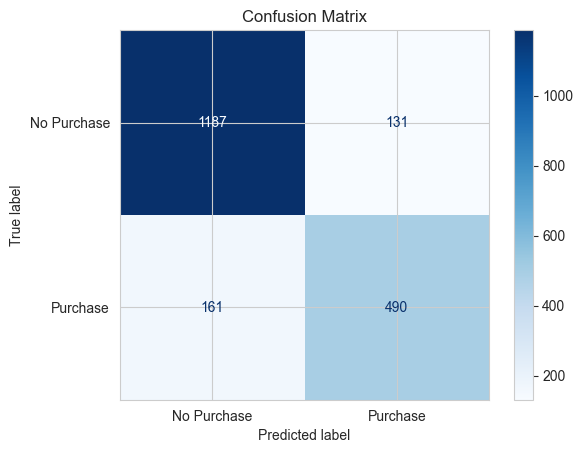

In [77]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Predict Classes (returns 0 or 1 directly)
# XGBoost uses a default threshold of 0.5 here
y_pred = model_xgb.predict(X_val_xgb)
y_val_xgb_clean = y_val_xgb.astype(int)
# 2. Calculate F1 Score (Binary)
f1 = f1_score(y_val_xgb_clean, y_pred)

print(f"🏆 F1 Score (Threshold 0.5): {f1:.4f}")
print("-" * 30)

# 3. Detailed Report (Precision, Recall, Support)
print("\n📊 Classification Report:")
print(classification_report(y_val_xgb_clean, y_pred))

# 4. Visualize Confusion Matrix
cm = confusion_matrix(y_val_xgb_clean, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Purchase", "Purchase"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [71]:
# 1. Get Probabilities instead of classes
# This returns [Prob of 0, Prob of 1]. We take column 1.
y_probs = model_xgb.predict_proba(X_val_xgb)[:, 1]

# 2. Loop through thresholds to find the best F1
thresholds = np.arange(0.1, 0.9, 0.01)
best_f1 = 0
best_thresh = 0.5

for thresh in thresholds:
    # Create class predictions based on current threshold
    y_pred_temp = (y_probs > thresh).astype(int)
    y_val_xgb_clean = y_val_xgb.astype(int)
    # Calculate F1
    current_f1 = f1_score(y_val_xgb_clean, y_pred_temp)
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_thresh = thresh

print(f"🚀 Best F1 Score: {best_f1:.4f}")
print(f"🎯 Optimal Threshold: {best_thresh:.2f}")

# 3. Use this new threshold for your final decisions
final_preds = (y_probs > best_thresh).astype(int)

🚀 Best F1 Score: 0.7827
🎯 Optimal Threshold: 0.32


In [72]:
# 1. Predict on Test Data
y_pred_test = model_xgb.predict(X_test_xgb)

# 2. DO NOT run f1_score here (it will crash). 
# Instead, save to CSV:
submission = pd.DataFrame({
    "id": test_data["id"], # Make sure to load the IDs from the raw file
    "Purchase": y_pred_test
})
submission.to_csv("../data/submissions/xgboost_submission.csv", index=False)
print("✅ Submission file saved.")

✅ Submission file saved.


In [ ]:
test_data.head()


,id,Age,Gender,Reviews_Read,Price,Discount,Category,Items_In_Cart,Time_of_Day,Email_Interaction,Device_Type,Payment_Method,Referral_Source,Socioeconomic_Status_Score,Engagement_Score,AB_Bucket,Price_Sine,Session_ID,Day,Campaign_Period
0,1,20.0,1.0,4.0,12.773,32.0,4.0,7.0,morning,0.0,Desktop,PayPal,Direct,3.29,0.719369,1.0,0.651539,S0000001,82.0,True
1,2,27.0,1.0,3.0,80.720,12.0,0.0,3.0,evening,1.0,Mobile,Cash,Search_engine,3.06,3.896403,2.0,-0.974133,S0000002,100.0,False
2,3,NaN,0.0,3.0,95.771,11.0,3.0,5.0,afternoon,1.0,Desktop,Bank,Search_engine,2.52,0.419710,4.0,-0.820665,S0000004,72.0,False
3,4,NaN,0.0,5.0,568.440,25.0,3.0,0.0,afternoon,0.0,Tablet,Bank,Ads,NaN,NaN,6.0,0.163338,S0000006,92.0,False
4,5,54.0,0.0,2.0,83.854,37.0,0.0,3.0,evening,0.0,Mobile,Cash,Social_media,9.58,2.489888,5.0,-0.998551,S0000012,99.0,False


In [ ]:
df.tail()

,id,Age,Gender,Reviews_Read,Price,Discount,Category,Items_In_Cart,Time_of_Day,Email_Interaction,Device_Type,Payment_Method,Referral_Source,Socioeconomic_Status_Score,Engagement_Score,AB_Bucket,Price_Sine,Session_ID,Day,Campaign_Period,Purchase
19995,6261,65.0,0.0,3.0,960.636,32.0,0.0,3.0,afternoon,0.0,Desktop,Credit,Search_engine,2.50,4.054900,4.0,0.038399,S0019982,74.0,False,NaN
19996,6262,41.0,1.0,4.0,213.249,12.0,3.0,6.0,evening,1.0,Tablet,Cash,Search_engine,NaN,2.271717,6.0,-0.658786,S0019984,92.0,False,NaN
19997,6263,NaN,0.0,2.0,949.118,10.0,4.0,10.0,evening,0.0,Mobile,PayPal,Email,8.28,1.279572,1.0,0.627468,S0019986,77.0,True,NaN
19998,6264,20.0,0.0,2.0,606.627,3.0,0.0,8.0,evening,1.0,Mobile,Cash,Search_engine,6.08,2.875428,6.0,0.755239,S0019998,83.0,True,NaN
19999,6265,21.0,0.0,2.0,606.350,37.0,0.0,6.0,morning,0.0,Desktop,Cash,Social_media,6.96,0.203022,1.0,0.765236,S0020000,97.0,False,NaN


In [ ]:
initial_data.head()

,id,Age,Gender,Reviews_Read,Price,Discount,Category,Items_In_Cart,Time_of_Day,Email_Interaction,Device_Type,Payment_Method,Referral_Source,Socioeconomic_Status_Score,Engagement_Score,AB_Bucket,Price_Sine,Session_ID,Day,Campaign_Period,Purchase
0,1,NaN,1.0,3.0,592.975,22.0,1.0,6.0,afternoon,0.0,Mobile,Credit,Social_media,7.26,1.856520,3.0,0.999047,S0000003,59,False,0
1,2,25.0,1.0,1.0,511.279,12.0,0.0,3.0,morning,1.0,Tablet,Cash,Social_media,8.30,1.868138,5.0,-0.129689,S0000005,29,True,1
2,3,22.0,0.0,3.0,218.360,2.0,1.0,4.0,evening,1.0,Mobile,Bank,Social_media,6.61,1.223445,0.0,-0.421646,S0000007,16,False,0
3,4,24.0,0.0,3.0,313.781,1.0,3.0,0.0,evening,1.0,Mobile,PayPal,Social_media,10.51,0.359684,1.0,-0.988239,S0000008,53,False,0
4,5,35.0,1.0,1.0,495.088,13.0,0.0,2.0,evening,0.0,Mobile,Cash,Social_media,8.33,3.848580,2.0,0.695737,S0000009,10,False,0
